##Simulating sky images, with source noise and astrometric noise
###Over another image
####Written by Sergio Hernandez Charpak
####24/06/2016

In [242]:
%pylab inline
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
#from pylab import *
import cv2
from astropy.io import fits
#Running bash
import subprocess

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [243]:
#Function to make the histogram of an image given the number of bins and the image
def make_histogram(image, bins, title):
    hist, bins = np.histogram(image.ravel(),bins=bins)
    n_bins = np.zeros(len(hist))
    for i in range(len(hist)):
        n_bins[i] = (bins[i]+bins[i+1])/2.0
    fig = plt.figure(figsize = (8,8))
    plt.step( n_bins,hist,linewidth=3 )
    plt.xlabel("Gray scale level", fontsize=20)
    plt.ylabel("Number of pixels", fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.grid()
    plt.title(title, fontsize=20)
    #Uncomment to save as png
    #plt.savefig("path_images+'histogram_new.png",format = "png")
#Log scale
def make_histogram_logscale(image, bins, title):
    hist, bins = np.histogram(image.ravel(),bins=bins)
    n_bins = np.zeros(len(hist))
    for i in range(len(hist)):
        n_bins[i] = (bins[i]+bins[i+1])/2.0
    fig = plt.figure(figsize = (8,8))
    plt.step( np.log10(n_bins),np.log10(hist),linewidth=3 )
    plt.xlabel("Gray scale level, $log_{10}$ scale", fontsize=20)
    plt.ylabel("Number of pixels, $log_{10}$ scale", fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.grid()
    plt.title(title, fontsize=20)
    #Uncomment to save as png
    #plt.savefig("path_images+'histogram_new.png",format = "png")

In [244]:
#Function to make a row x col gaussian white noise with given std
def gaussian_white_noise(row,col,std):
    mean = 0
    gauss_noise = np.random.normal(mean, std, (row,col))
    gauss_noise = gauss_noise.reshape(row, col)
    return gauss_noise

# Auxiliary functions to calculate create gaussians
def gaussian(x, mu, sigma):
    return exp( -(((x-mu)/(sigma))**2)/2.0 )

def get_gaussian(kernel_radius, sigma):
    hkernel = [gaussian(x, kernel_radius, sigma) for x in range(2*kernel_radius+1)]
    vkernel = [x for x in hkernel]
    kernel2d = [[xh*xv for xh in hkernel] for xv in vkernel]
    kernelsum = sum([sum(row) for row in kernel2d])
    kernel2d = [[x/kernelsum for x in row] for row in kernel2d]
    return array(kernel2d)

#Function which injects a gaussian source with noise in a given image
def inject_noisy_gaussian_source(image, x,y, size, std_noise, std_source, amplitude_source):
    gauss_noise = gaussian_white_noise(size,size,std_noise)
    radius = int(size/2)
    #gaussian = get_gaussian(2, 1.)
    gaussian = get_gaussian(radius, std_source)
    gaussian = gaussian*amplitude_source
    gaussian_plus_noise = gaussian + gauss_noise
    i_ini, j_ini = int(x-size/2),int(y-size/2)
    for i in range (size):
        for j in range (size):
            image[i_ini + i, j_ini + j] = image[i_ini + i, j_ini + j] + gaussian_plus_noise[i,j]
    return image

In [245]:
def inject_gaussian_source(image, x,y, amplitude_source):
    cv2.circle(image, (y,x), 1, (amplitude_source, amplitude_source, amplitude_source), -1) 

In [246]:
path_original = './Fits/twinkles/imsim_846_R22_S11_C04_E000.fits'
path_images = './Images/Twinkles_NoiseAstrometric/'

####Note
This code can produce an error if the images already exist. We first erase the existing images.

In [247]:
comando = 'rm '+path_images+'*.fits'
process =subprocess.Popen(comando,stdout=subprocess.PIPE, stderr=None, shell=True)
resultsString=process.communicate()
print resultsString

('', None)


<p>We want to simulate:</p>
<ul>
<li>Sky Flux</li>
<li>Delta sources</li>
<li>Background noise</li>
<li>Source noise</li>
<li><b>Astrometric Noise</b></li>
</ul>
Our two outputs are going to be pairs of New/Reference:
<ul>
<li>Sky substracted Image</li>
<li>Image with the background</li>
</ul>

In [248]:
Img_orig = fits.getdata(path_original)
Img_list = fits.open(path_original)

In [249]:
Img_list.info()

Filename: ./Fits/twinkles/imsim_846_R22_S11_C04_E000.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU     391   (510, 2010)   int16   


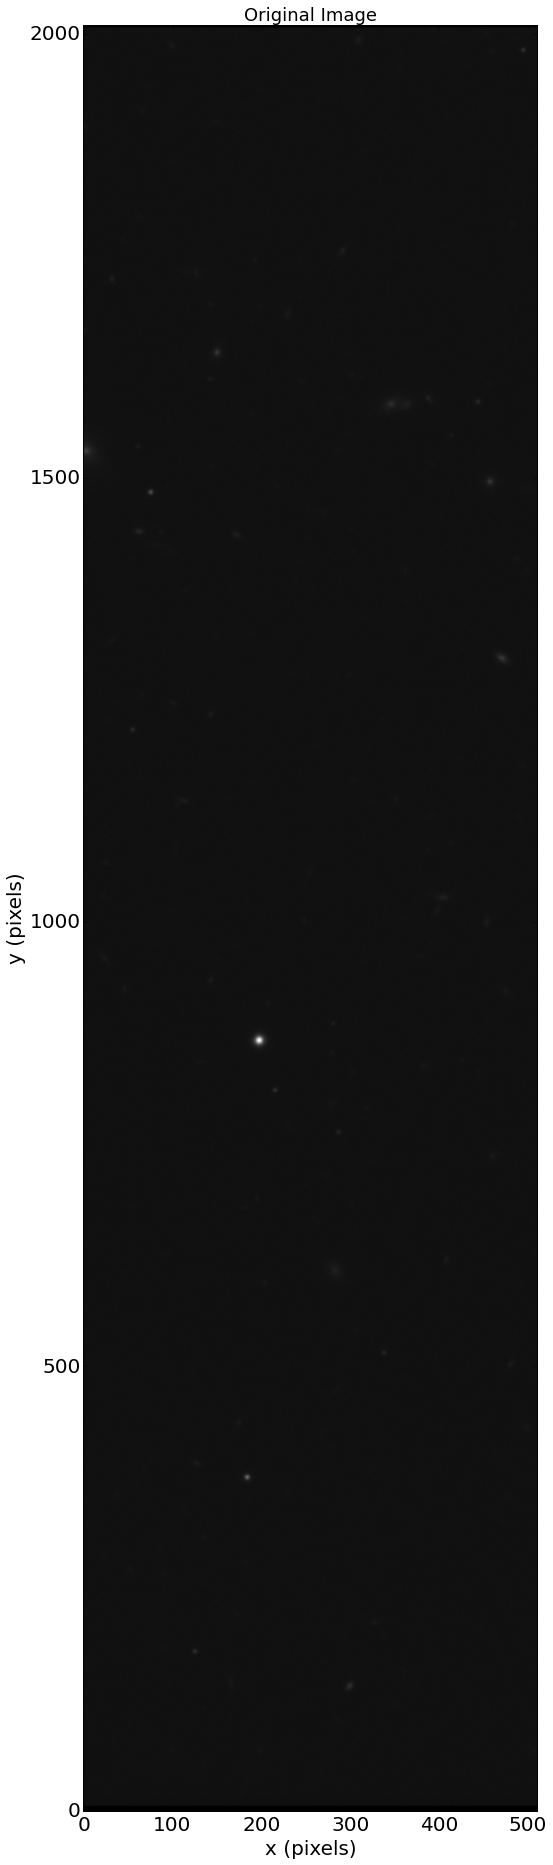

In [250]:
fig = plt.figure(figsize = (16,32))
plt.imshow(Img_orig, cmap = 'gray', origin='lower', norm=LogNorm())
plt.title('Original Image', fontsize=18)
plt.xlabel("x (pixels) ", fontsize=20)
plt.ylabel("y (pixels) ", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:23: RuntimeWarning: divide by zero encountered in log10


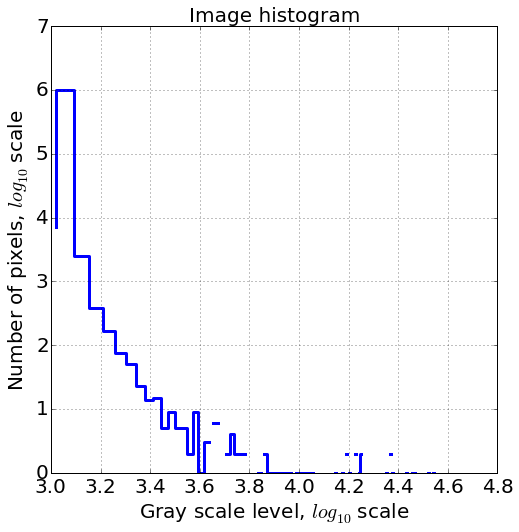

In [251]:
make_histogram_logscale(Img_orig,255,"Image histogram")

In [252]:
image_sorted = np.sort(Img_orig.ravel())

In [253]:
#Threshold to take the points near 0
threshold_sigma = 5000

In [254]:
mask = np.where(image_sorted<threshold_sigma)
image_sorted_thresholded = image_sorted[mask]

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:23: RuntimeWarning: divide by zero encountered in log10


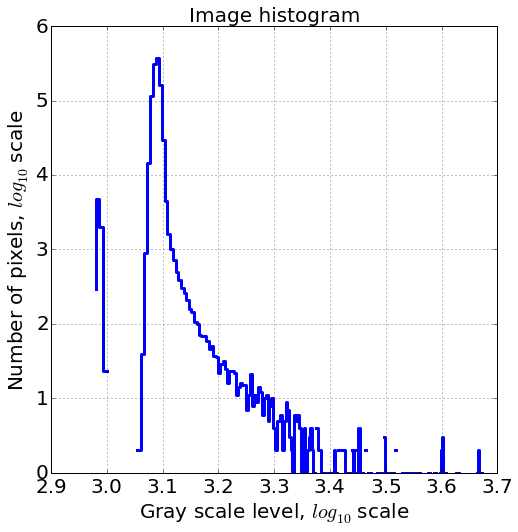

In [255]:
make_histogram_logscale(image_sorted_thresholded,255,"Image histogram")

In [256]:
#Threshold to take the peak
threshold_sigma_min = 1100
mask = np.where(image_sorted_thresholded>threshold_sigma_min)
image_sorted_thresholded = image_sorted_thresholded[mask]

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:23: RuntimeWarning: divide by zero encountered in log10


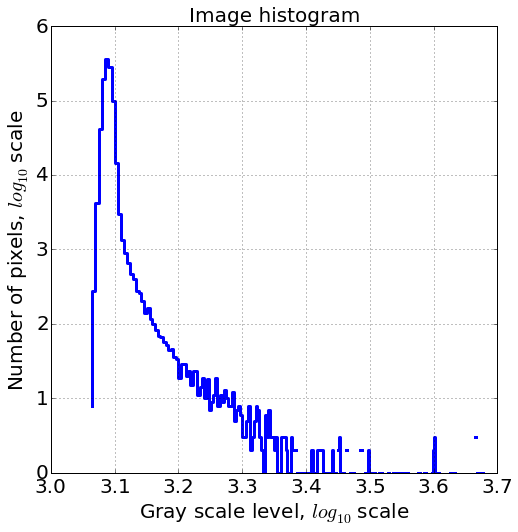

In [257]:
make_histogram_logscale(image_sorted_thresholded,255,"Image histogram")

In [258]:
threshold_sigma = 1500
mask = np.where(image_sorted_thresholded<threshold_sigma)
image_sorted_thresholded_1500 = image_sorted_thresholded[mask]

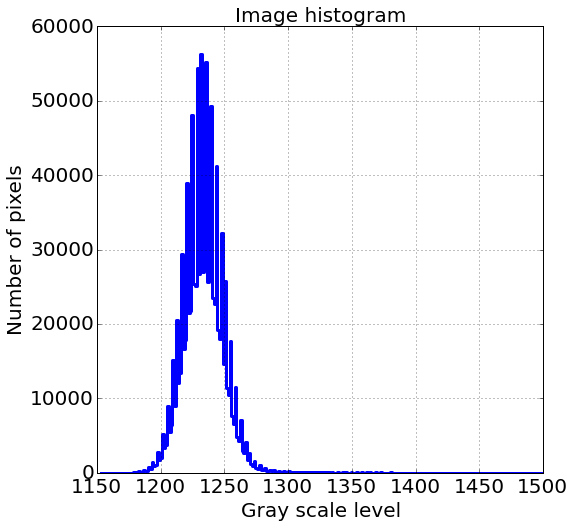

In [259]:
make_histogram(image_sorted_thresholded_1500,255,"Image histogram")

In [260]:
(mu_sky, sigma_sky) = norm.fit(image_sorted_thresholded)

In [261]:
print (mu_sky, sigma_sky)

(1227.6322, 30.386303)


In [262]:
#Sky flux
height, width = Img_orig.shape
sky_image = np.zeros(Img_orig.shape)
mean = 0
for i in range(height):
    for j in range(width):
        sky_image[i,j] = sky_image[i,j] + np.random.normal(mu_sky, sigma_sky)
fits.PrimaryHDU(sky_image).writeto(path_images+'sky_image.fits')
#scipy.misc.toimage(sky_image, cmin=np.min(sky_image), cmax=np.max(sky_image)).save(path_images+'skyImage.jpg')
#cv2.imwrite(path_images+'skyImage.jpg', sky_image)

###Inyection of the sources

In [263]:
height, width = Img_orig.shape
reference = np.zeros((height,width))

In [264]:
print height,width

2010 510


In [265]:
#properties for the injected source
#size = 11
amplitude_source = 200
#std_source = 3.0
#std_noise = np.sqrt(sigma_sky**2.0 + amplitude_source)
#We are puttting everything in the lower part of the image
x, y = (width/2,width/2)
#injecting the source
#reference = inject_noisy_gaussian_source(reference, x,y, size, std_noise, std_source, amplitude_source)
inject_gaussian_source(reference, x,y, amplitude_source)

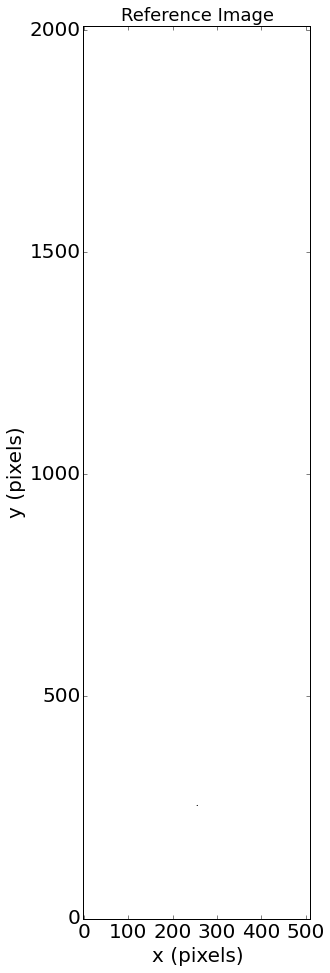

In [266]:
fig = plt.figure(figsize = (8,16))
plt.imshow(reference, cmap = 'gray', origin='lower', norm=LogNorm())
plt.title('Reference Image', fontsize=18)
plt.xlabel("x (pixels) ", fontsize=20)
plt.ylabel("y (pixels) ", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)

In [267]:
#properties for the injected source
#size = 11
amplitude_source = 300
#std_source = 3.0
#std_noise = np.sqrt(sigma_sky**2.0 + amplitude_source)
#We are puttting everything in the lower part of the image
x, y = (width/3, width/4)
#injecting the source
#reference = inject_noisy_gaussian_source(reference, x,y, size, std_noise, std_source, amplitude_source)
inject_gaussian_source(reference, x,y, amplitude_source)

In [268]:
cv2.ellipse(reference,(int(width*0.8), int(width*0.4)),(20,40),30,0,360,(100),-1)


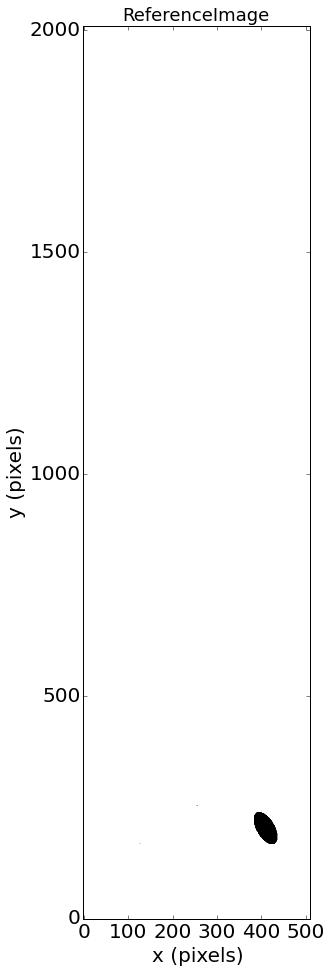

In [269]:
fig = plt.figure(figsize = (8,16))
plt.imshow(reference, cmap = 'gray', origin='lower', norm=LogNorm())
plt.title('ReferenceImage', fontsize=18)
plt.xlabel("x (pixels) ", fontsize=20)
plt.ylabel("y (pixels) ", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)

In [270]:
newimage = reference.copy()

In [271]:
#properties for the injected transient
#size = 11
amplitude_source = (300)
#std_source = 3.0
#std_noise = np.sqrt(sigma_sky**2.0 + amplitude_source)
#We are puttting everything in the lower part of the image
x, y = (width/5, width/5)
#injecting the source
#newimage = inject_noisy_gaussian_source(newimage, x,y, size, std_noise, std_source, amplitude_source)
inject_gaussian_source(newimage, x,y, amplitude_source)

In [272]:
print x,y, amplitude_source

102 102 300


In [273]:
#properties for the injected source
#size = 11
amplitude_source = 200
#std_source = 3.0
#std_noise = np.sqrt(sigma_sky**2.0 + amplitude_source)
#We are puttting everything in the lower part of the image
x, y = (2*width/5,4*width/5)
#injecting the source
#newimage = inject_noisy_gaussian_source(newimage, x,y, size, std_noise, std_source, amplitude_source)
inject_gaussian_source(newimage, x,y, amplitude_source)

In [274]:
print x,y, amplitude_source

204 408 200


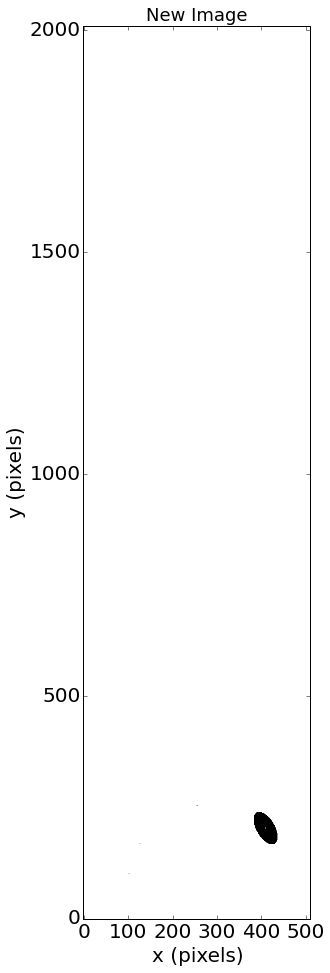

In [275]:
fig = plt.figure(figsize = (8,16))
plt.imshow(newimage, cmap = 'gray', origin='lower', norm=LogNorm())
plt.title('New Image', fontsize=18)
plt.xlabel("x (pixels) ", fontsize=20)
plt.ylabel("y (pixels) ", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)

In [276]:
#PSFs
reference = cv2.GaussianBlur(reference, (3,3), 3, 3)
newimage = cv2.GaussianBlur(newimage, (3,3), 3, 3)

In [277]:
reference = Img_orig + reference
newimage = Img_orig + newimage

In [278]:
#The background noise is no longer calculated from one point.
#It is calculated locally for each pixel value.
row, col = sky_image.shape
mean = 0
for i in range(row):
    for j in range(col):
        noise_ref = np.random.normal(mean, np.sqrt(reference[i,j]), (1))
        noise_new = np.random.normal(mean, np.sqrt(newimage[i,j]), (1))
        reference[i,j] = reference[i,j] + noise_ref
        newimage[i,j] = newimage[i,j] + noise_new
#print np.mean(np.sqrt(reference)), np.mean(np.sqrt(new_image))

In [279]:
print np.std(reference), np.std(newimage)

154.344732722 154.595458882


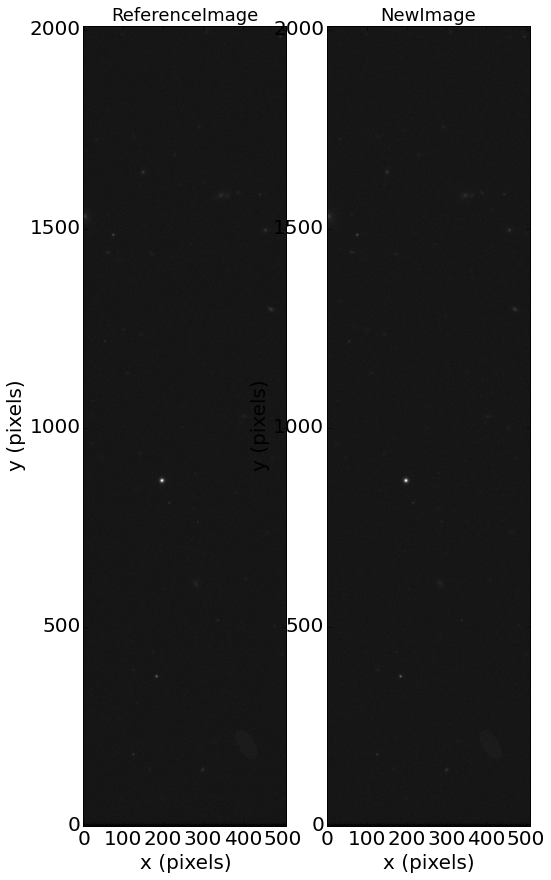

In [280]:
fig = plt.figure(figsize = (8,16))
fig.add_subplot(1, 2, 1)  # this line outputs images side-by-side
plt.imshow(reference, cmap = 'gray', origin='lower', norm=LogNorm())
plt.title('ReferenceImage', fontsize=18)
plt.xlabel("x (pixels) ", fontsize=20)
plt.ylabel("y (pixels) ", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
fig.add_subplot(1, 2, 2)  # this line outputs images side-by-side
plt.imshow(newimage,  cmap = 'gray', origin='lower', norm=LogNorm())
plt.title('NewImage', fontsize=18)
plt.xlabel("x (pixels) ", fontsize=20)
plt.ylabel("y (pixels) ", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.show()

In [281]:
#These are the measured images with background
fits.PrimaryHDU(reference).writeto(path_images+'ReferenceImage_b.fits')
fits.PrimaryHDU(newimage).writeto(path_images+'NewImage_b.fits')
#scipy.misc.toimage(reference, cmin=np.min(reference), cmax=np.max(reference)).save(path_images+'ReferenceImage_b.jpg')
#scipy.misc.toimage(new_image, cmin=np.min(new_image), cmax=np.max(new_image)).save(path_images+'NewImage_b.jpg')
#cv2.imwrite(path_images+'NewImage_b.jpg', new_image)
#cv2.imwrite(path_images+'ReferenceImage_b.jpg', reference)

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:23: RuntimeWarning: divide by zero encountered in log10


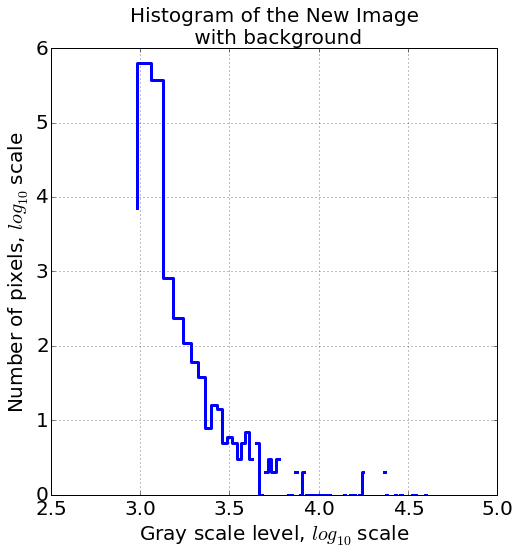

In [282]:
make_histogram_logscale(newimage,255, "Histogram of the New Image \n with background")

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:23: RuntimeWarning: divide by zero encountered in log10


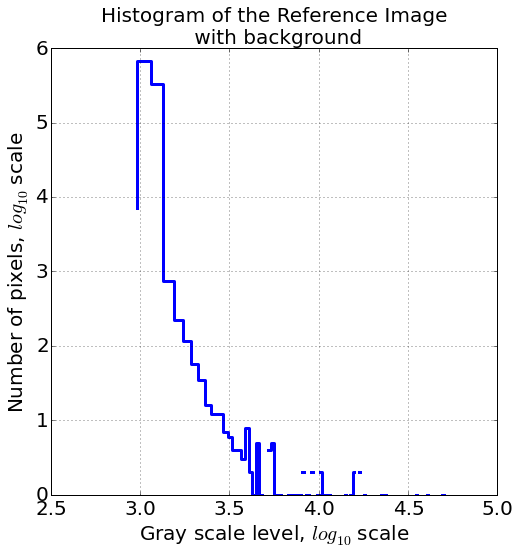

In [283]:
make_histogram_logscale(reference,255,"Histogram of the Reference Image \n with background")

In [284]:
#We substract the sky to get the final results
reference = (reference - sky_image.copy())
newimage = (newimage - sky_image.copy())

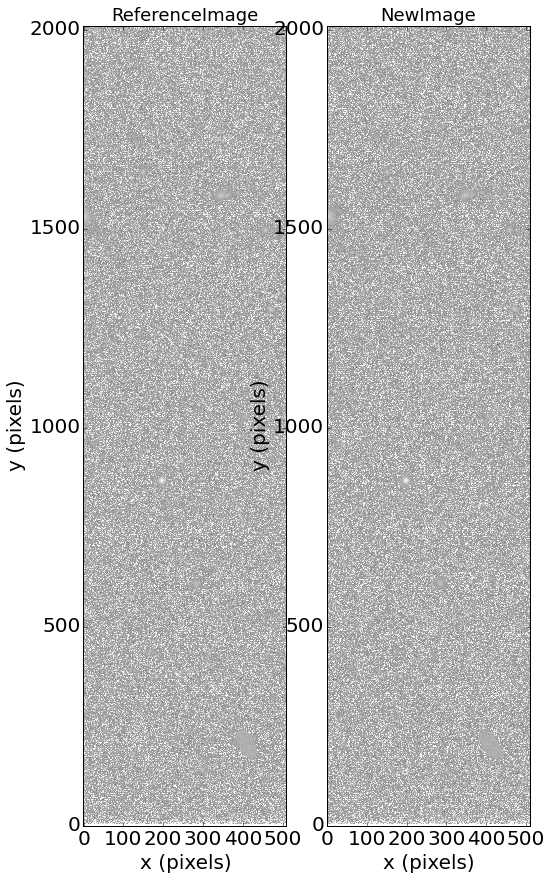

In [285]:
fig = plt.figure(figsize = (8,16))
fig.add_subplot(1, 2, 1)  # this line outputs images side-by-side
plt.imshow(reference, cmap = 'gray', origin='lower', norm=LogNorm())
plt.title('ReferenceImage', fontsize=18)
plt.xlabel("x (pixels) ", fontsize=20)
plt.ylabel("y (pixels) ", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
fig.add_subplot(1, 2, 2)  # this line outputs images side-by-side
plt.imshow(newimage,  cmap = 'gray', origin='lower', norm=LogNorm())
plt.title('NewImage', fontsize=18)
plt.xlabel("x (pixels) ", fontsize=20)
plt.ylabel("y (pixels) ", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.show()

In [286]:
fits.PrimaryHDU(reference).writeto(path_images+'ReferenceImage.fits')
fits.PrimaryHDU(newimage).writeto(path_images+'NewImage.fits')
#scipy.misc.toimage(reference, cmin=np.min(reference), cmax=np.max(reference)).save(path_images+'ReferenceImage.jpg')
#scipy.misc.toimage(new_image, cmin=np.min(new_image), cmax=np.max(new_image)).save(path_images+'NewImage.jpg')
#cv2.imwrite(path_images+'NewImage.jpg', new_image)
#cv2.imwrite(path_images+'ReferenceImage.jpg', reference)

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:23: RuntimeWarning: invalid value encountered in log10
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:23: RuntimeWarning: divide by zero encountered in log10


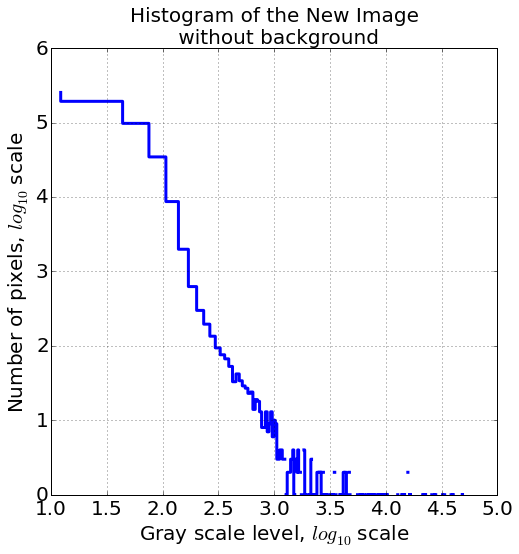

In [287]:
make_histogram_logscale(newimage,1555,"Histogram of the New Image \n without background")

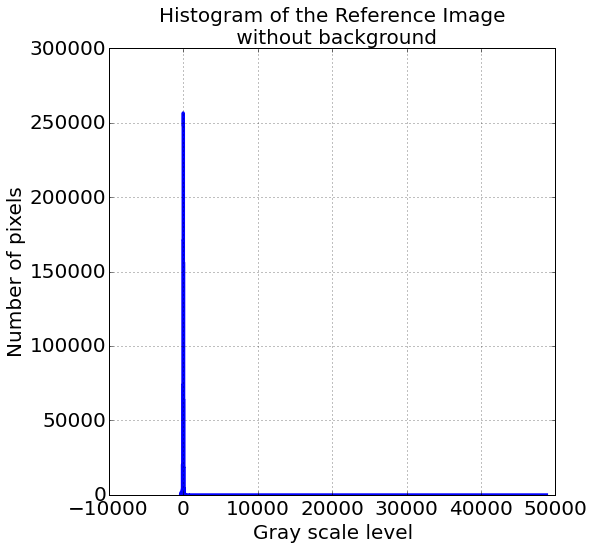

In [288]:
make_histogram(reference,1500, "Histogram of the Reference Image \n without background")